In [1]:
import tensorflow as tf 
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import numpy as np
import string

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# 载入之前训练好的模型
model = load_model('Best_Captcha_tfdata.h5')

In [3]:
# 字符包含所有数字和所有大小写英文字母，一共62个
characters = string.digits + string.ascii_letters
# 类别数
num_classes = len(characters)
# 批次大小
batch_size = 64
# 测试集数据，大约10000张图片
# 事先用captcha模块生成，长度都是4
test_dir = "./captcha/test/"

In [4]:
# 获取所有验证码图片路径和标签
def get_filenames_and_classes(dataset_dir):
    # 存放图片路径
    photo_filenames = []
    # 存放图片标签
    y = []
    for filename in os.listdir(dataset_dir):
        # 获取文件完整路径
        path = os.path.join(dataset_dir, filename)
        # 保存图片路径
        photo_filenames.append(path)
        # 取文件名前4位，也就是验证码的标签
        captcha_text = filename[0:4]
        # 定义一个空label
        label = np.zeros((4, num_classes), dtype=np.uint8)
        # 标签转独热编码
        for i, ch in enumerate(captcha_text):
            # 设置标签，独热编码one-hot格式
            # characters.find(ch)得到ch在characters中的位置，可以理解为ch的编号
            label[i, characters.find(ch)] = 1
        # 保存独热编码的标签
        y.append(label)
    # 返回图片路径和标签
    return np.array(photo_filenames),np.array(y)

In [5]:
# 获取测试集图片路径和标签
x_test,y_test = get_filenames_and_classes(test_dir)

In [6]:
# 图像处理函数
# 获得每一条数据的图片路径和标签
def image_function(filenames, label):
    # 根据图片路径读取图片内容
    image = tf.io.read_file(filenames)
    # 将图像解码为jpeg格式的3维数据
    image = tf.image.decode_jpeg(image, channels=3)   
    # 归一化
    image = tf.cast(image, tf.float32) / 255.0
    # 返回图片数据和标签
    return image, label

In [7]:
# 标签处理函数
# 获得每一个批次的图片数据和标签
def label_function(image, label):
    # transpose改变数据的维度，比如原来的数据shape是(64,4,62)
    # 这里的64是批次大小，验证码长度为4有4个标签，62是62个不同的字符
    # tf.transpose(label,[1,0,2])计算后得到的shape为(4,64,62)
    # 原来的第1个维度变成了第0维度，原来的第0维度变成了1维度，第2维不变
    # (64,4,62)->(4,64,62)
    label = tf.transpose(label,[1,0,2])
    # 返回图片内容和标签，注意这里标签的返回，我们的模型会定义4个任务，所以这里返回4个标签
    # 每个标签的shape为(64,62)，64是批次大小，62是独热编码格式的标签
    return image, (label[0],label[1],label[2],label[3])

In [13]:
# 创建dataset对象，传入测试集图片路径和标签
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# 打乱数据，buffer_size定义数据缓冲器大小，随意设置一个较大的值
# reshuffle_each_iteration=True，每次迭代都会随机打乱
dataset_test = dataset_test.shuffle(buffer_size=1000,reshuffle_each_iteration=True)
# map-可以自定义一个函数来处理每一条数据
dataset_test = dataset_test.map(image_function)
# 数据重复生成1个周期
dataset_test = dataset_test.repeat(1)
# 定义批次大小
dataset_test = dataset_test.batch(batch_size)
# 注意这个map和前面的map有所不同，第一个map在batch之前，所以是处理每一条数据
# 这个map在batch之后，所以是处理每一个batch的数据
dataset_test = dataset_test.map(label_function)

In [9]:
# 用于统计准确率
acc_sum = 0
# 统计批次数量
n = 0
for x,y in dataset_test:
    # 计算批次数量
    n+=1
    # 进行一个批次的预测
    pred = model.predict(x)
    # 获得对应编号
    pred = np.argmax(pred, axis=-1)
    # 获得标签数据
    label = np.argmax(y, axis=-1)
    # 计算这个批次的准确率然后累加到总的准确率统计中
    acc_sum += (pred == label).all(axis=0).mean()
# 计算测试集准确率
print(acc_sum / n)

0.8631052107614607


In [24]:
# 把标签编号变成字符串
# 如[2,34,22,45]->'2ymJ'
def labels_to_text(labels):
    ret = []
    for l in labels:
        ret.append(characters[l])
    return "".join(ret)

# 把一个批次的标签编号都变成字符串
def decode_batch(labels):
    ret = []
    for label in labels:
        ret.append(labels_to_text(label))
    return np.array(ret)

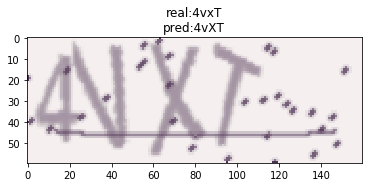

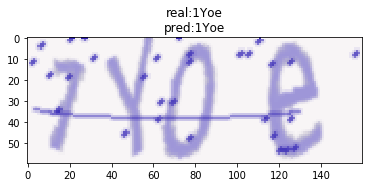

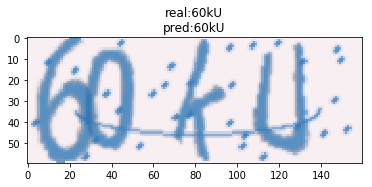

In [37]:
# 获得一个批次数据
x,y = next(iter(dataset_test))
# 预测结果
pred = model.predict(x)
# 获得对应编号
pred = np.argmax(pred, axis=-1)
# shape转换
# (4,64)->(64,4)
pred = pred.T
# 获得标签数据
label = np.argmax(y, axis=-1)
# (4,64)->(64,4)
label = label.T
# 根据编号获得对应验证码
pred = decode_batch(pred)
# 根据编号获得对应验证码
label = decode_batch(label)
# 获取前3张图片数据
for i,image in enumerate(x[:3]):
    # 显示图片
    plt.imshow(image)
    # 设置标题
    plt.title('real:%s\npred:%s'%(label[i],pred[i]))
    plt.show()